# 외부데이터세트로 일반화 성능테스트

학습에 전혀 사용하지 않은 모집단을 제주 B초등학교에서 추가로 수집하여  
서울 A초등학교로 학습한 모델이 이 외부데이터 세트인 B초등학교에서도 성능이 잘 나오는지 테스트하였다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as ms
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import precision_recall_fscore_support as sk
import pandas as pd 
import os

In [2]:
os.chdir("..")
path=os.getcwd()

In [3]:
path

'c:\\jupyter\\Explainable Healthcare framework\\Explainable_healthcareframework'

## 제주 B초등학교 테스트 데이터셋 불러오기

In [4]:
jeju_data=pd.read_csv(path+"\\data\\5.제주초_df_final.csv",encoding="cp949")

## ID 라벨 인코딩

In [5]:
from Datapreprocessing.id_labelencoding import LabelEncoderWrapper 

df_encoder = LabelEncoderWrapper(jeju_data, 'ID')
df_encoder.fit()
df_encoder.transform()

## m day n term

일별 데이터를 다루기 때문에 처음에 접근한 방법으로는 몸무게의 변동이 거의 없을 수 밖에 없었다.   
그래서 14일치 묶음으로 1일 윈도우로 이동하면서 몸무게 변동의 유의미한 차이를 만들기 위한 데이터세트를 구축하였다.  
따라서 한 로우에 14일치 평균 그리고 다음 로우는 그 다음날부터 14일치 평균값이다. 

In [6]:
from Datapreprocessing.M_day_N_term import RollingAveragesCalculator
M_day=14
n_term=1
columns_to_average = ["ID",'height', 'weight', 'step count', 'burned calorie', 'eat calorie', 'sleep time']
calculator = RollingAveragesCalculator(jeju_data)
result_df = calculator.calculate_averages(columns_to_average, M_day, n_term)

In [7]:
name='{}day_{}term'.format(M_day,n_term)
print(name)

14day_1term


## 라벨링

라벨링은 임계값 몸무게 변동 차이 100g을 기준으로 이전 평균 몸무게 보다 증가하면 3, 유지면 2, 감소면 1로 라벨링하였다.    

In [8]:
from Datapreprocessing.labeling import WeightChangeLabeler

Threshhold=0.1 # 몸무게가 얼마나 차이나야 변했다고 정할 것 인지 정하는 임계값
labeler = WeightChangeLabeler(result_df, Threshhold)
labeled_df = labeler.label_weight_changes()
print(labeled_df)

      ID  height     weight   step count  burned calorie  eat calorie  \
0      0   143.0  33.392857  7001.748813       52.983568  3082.788763   
1      0   143.0  33.428571  7179.177385       50.842598  2967.285192   
2      0   143.0  33.464286  7048.891670       48.194152  2946.285192   
3      0   143.0  33.492857  6741.605956       48.930571  3092.367841   
4      0   143.0  33.521429  6598.748813       47.395000  3331.906238   
...   ..     ...        ...          ...             ...          ...   
3263  75   150.4  44.564286   686.285714       58.310000  2613.357143   
3264  75   150.4  44.621429   704.857143       58.310000  2754.357143   
3265  75   150.4  44.678571   722.976190       58.310000  2854.892857   
3266  75   150.4  44.735714   740.642857       58.310000  2914.964286   
3267  75   150.4  44.792857   757.857143       58.310000  2934.571429   

      sleep time  Start_Day Label  
0     437.964286          0     2  
1     441.178571          1     2  
2     447.17857

In [9]:
labeled_df['Label']=labeled_df['Label'].astype(int)

In [10]:
labeled_df['Label'].value_counts()

Label
2    2859
3     266
1     143
Name: count, dtype: int64

###  데이터 세트 로드

In [11]:
data=labeled_df.iloc[:,[1,2,3,4,5,6,-1]]
train=data.iloc[:,:-1]
train_targets=data.iloc[:,-1]

### 데이터 세트 셋업

In [12]:
X_test=train.to_numpy()
y_test=train_targets-1

In [13]:
test_np = X_test

test_targets_np=y_test.astype(int)

### 생성 method 리스트

In [14]:
Generation_list = ['smote','adasyn','copulagan','ctgan','nbsynthetic']

## 모델 불러오기

### 제안한 모델

In [15]:
import os

In [16]:
notebook_path = os.path.abspath('.')
print("노트북 경로:", notebook_path)

노트북 경로: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework


In [17]:
# # 먼저 nbimport 설치 (처음 한번만)
# !pip install nbimport

In [18]:
import nbimport
from encoding_tabnet import train_tabnet_classifier, create_augmented_features2, create_augmented_features

In [20]:
import pandas as pd
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support as sk
from encoding_tabnet import train_tabnet_classifier, create_augmented_features2,create_augmented_features
import os

# 현재 디렉토리 및 프로젝트 루트 디렉토리 경로 설정
# current_dir = os.path.dirname(os.path.abspath(__file__))
# path = os.path.dirname(current_dir)

def evaluate_generalization():
    """모델의 일반화 성능을 외부 데이터셋으로 평가하는 함수"""
    # 빈 리스트 생성하여 결과 저장
    results = []
    
    # 평가할 생성 모델 리스트
    Generation_list = ['smote', 'adasyn', 'copulagan', 'ctgan', 'nbsynthetic']
    
    # 외부 테스트 데이터 로드
    print(f"외부 테스트 데이터 크기: {test_np.shape}, 타겟 크기: {test_targets_np.shape}")
    print(f"타겟 클래스 분포: {np.unique(test_targets_np, return_counts=True)}")
    
    for generation in Generation_list:
        print(f"\n{generation} 모델로 외부 데이터 평가 중...")
        
        try:
            # TabNet 모델 로드
            tabnet_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed_tabnetEmbedd2.pickle'
            with open(tabnet_path, 'rb') as f:
                tabnet_model = pickle.load(f)
            print(f"TabNet 모델 로드 성공: {tabnet_path}")
            
            # XGBoost 모델 로드
            xgb_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
            with open(xgb_path, 'rb') as f:
                xgb_model = pickle.load(f)
            print(f"XGBoost 모델 로드 성공: {xgb_path}")
            
            # TabNet 임베딩 추출 및 특성 증강
            test_features = create_augmented_features(tabnet_model, test_np)
            print(f"TabNet 특성 증강 완료: {test_features.shape}")
            
            # TabNet으로 확률 예측
            tabnet_probs = tabnet_model.predict_proba(test_np)
            
            # XGBoost로 확률 예측
            xgb_probs = xgb_model.predict_proba(test_features)


            # # 확률 합산 (앙상블)
            combined_probs = (tabnet_probs + xgb_probs)
            
            # # 가장 높은 확률을 가진 클래스 선택
            ensemble_pred = np.argmax(combined_probs, axis=1)

            # 예측값 확인
            unique_values = np.array(list(set(ensemble_pred)))
            print(f"Unique values in prediction: {unique_values}")
            
            # 메트릭 계산
            accuracy = accuracy_score(test_targets_np, ensemble_pred)
            f1 = f1_score(test_targets_np, ensemble_pred, average='weighted')
            precision, recall = sk(test_targets_np, ensemble_pred, beta=1, average='weighted')[:2]
            
            results.append({
                'Model': f"{generation}-proposed_external",
                'Accuracy': round(accuracy, 5),
                'F1score': round(f1, 5), 
                'Precision': round(precision, 5),
                'Recall': round(recall, 5)
            })
            
        except Exception as e:
            print(f"{generation} 모델 평가 중 오류 발생: {str(e)}")
    
    # 결과를 데이터프레임으로 변환
    df_results = pd.DataFrame(results)
    print("\n외부 데이터셋에 대한 모델 성능 요약:")
    print(df_results)
    
    # 결과 저장
    output_path = path + '\\3_1.Training_XAI_Proposed\\external_test_results.csv'
    df_results.to_csv(output_path, index=False)
    print(f"결과가 {output_path}에 저장되었습니다.")
    
    return df_results,ensemble_pred

if __name__ == "__main__":
    df_results,ensemble_pred=evaluate_generalization()

외부 테스트 데이터 크기: (3268, 6), 타겟 크기: (3268,)
타겟 클래스 분포: (array([0, 1, 2]), array([ 143, 2859,  266], dtype=int64))

smote 모델로 외부 데이터 평가 중...
TabNet 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\smote_proposed_tabnetEmbedd2.pickle
XGBoost 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\smote_proposed.pickle
원본 특성 shape: (3268, 6)
샘플별 마스크 평균 shape: (3268, 6)
TabNet 특성 증강 완료: (3268, 6)
Unique values in prediction: [0 1 2]

adasyn 모델로 외부 데이터 평가 중...
TabNet 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\adasyn_proposed_tabnetEmbedd2.pickle
XGBoost 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\adasyn_proposed.pickle
원본 특성 shape: (3268, 6)
샘플별 마스크 평균 shape: (3268, 6)
TabNet 특성 증강 완료: (3268, 6)
Uni

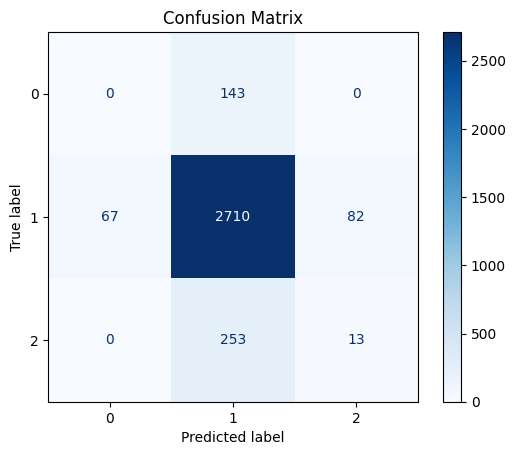

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix 계산
cm = confusion_matrix(test_targets_np, ensemble_pred)

# Confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [22]:
accuracy = accuracy_score(test_targets_np, ensemble_pred)

In [25]:
# 데이터프레임을 CSV 파일로 저장 (선택사항)
df_results.to_csv('proposed_model_metrics_externaltest.csv')

In [26]:
df_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-proposed_external,0.72368,0.74616,0.77129,0.72368
1,adasyn-proposed_external,0.72001,0.74385,0.77094,0.72001
2,copulagan-proposed_external,0.48562,0.58396,0.77431,0.48562
3,ctgan-proposed_external,0.50857,0.59997,0.78497,0.50857
4,nbsynthetic-proposed_external,0.83323,0.80078,0.77445,0.83323


## TabNet

In [27]:
# 빈 리스트 생성하여 결과 저장
results = []

for generation in Generation_list:
    with open(path+f'\\3_2.Training_XAI_VariousModel\\model_hist\\{generation}_proposed_tabnet_model.pickle', 'rb') as f:
        Tabnet_model = pickle.load(f)
        
    predict=Tabnet_model.predict(test_np).astype(int)
    # 각 메트릭 계산
    accuracy = accuracy_score(test_targets_np, predict)
    f1 = f1_score(test_targets_np, predict, average='weighted')
    precision, recall = sk(test_targets_np, predict, beta=1, average='weighted')[:2]
    
    # 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-tabnet",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # 리스트에 딕셔너리 추가
    results.append(result_dict)

# 데이터프레임 생성

df_tabnet_results = pd.DataFrame(results)
# 데이터프레임을 CSV 파일로 저장 (선택사항)
# df_results.to_csv('model_metrics.csv')

In [28]:
df_tabnet_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-tabnet,0.71389,0.74056,0.77071,0.71389
1,adasyn-tabnet,0.62362,0.68220,0.75745,0.62362
2,copulagan-tabnet,0.30386,0.39477,0.76099,0.30386
3,ctgan-tabnet,0.37729,0.48775,0.79114,0.37729
4,nbsynthetic-tabnet,0.82130,0.79877,0.78268,0.82130


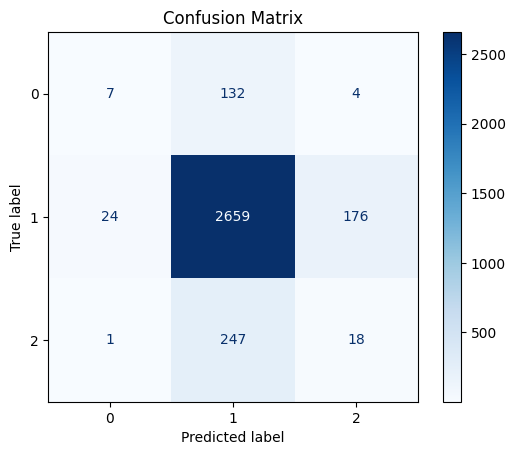

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix 계산
cm = confusion_matrix(test_targets_np, predict)

# Confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Decision Tree

In [30]:
import pickle

In [31]:
# 빈 리스트 생성하여 결과 저장
results = []

for generation in Generation_list:
    with open(path+f'\\3_2.Training_XAI_VariousModel\\model_hist\\{generation}_DT_model.pickle', 'rb') as f:
        DT_model = pickle.load(f)
        
    predict=DT_model.predict(test_np).astype(int)
    # 각 메트릭 계산
    accuracy = DT_model.score(test_np, test_targets_np)
    f1 = f1_score(test_targets_np, predict, average='weighted')
    precision, recall = sk(test_targets_np, predict, beta=1, average='weighted')[:2]
    
    # 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-Decision Tree",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # 리스트에 딕셔너리 추가
    results.append(result_dict)

# 데이터프레임 생성
df_DT_results = pd.DataFrame(results)

# 데이터프레임을 CSV 파일로 저장 (선택사항)
# df_results.to_csv('model_metrics.csv')

In [32]:
df_DT_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-Decision Tree,0.67075,0.71085,0.75832,0.67075
1,adasyn-Decision Tree,0.55171,0.63333,0.76439,0.55171
2,copulagan-Decision Tree,0.36781,0.47063,0.78362,0.36781
3,ctgan-Decision Tree,0.50520,0.59784,0.78723,0.50520
4,nbsynthetic-Decision Tree,0.75214,0.75827,0.76463,0.75214


## Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()

In [34]:
# 빈 리스트 생성하여 결과 저장
results = []

for generation in Generation_list:
    with open(path+f'\\3_2.Training_XAI_VariousModel\\model_hist\\{generation}_NB_model.pickle', 'rb') as f:
        NB_model = pickle.load(f)
    predict=NB_model.predict(test_np).astype(int)
    # 각 메트릭 계산
    accuracy = NB_model.score(test_np, test_targets_np)
    f1 = f1_score(test_targets_np, predict, average='weighted')
    precision, recall = sk(test_targets_np, predict, beta=1, average='weighted')[:2]
    
    # 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-Naive Bayes",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # 리스트에 딕셔너리 추가
    results.append(result_dict)

# 데이터프레임 생성
df_Naive_results = pd.DataFrame(results)

# 데이터프레임을 CSV 파일로 저장 (선택사항)
# df_results.to_csv('model_metrics.csv')

In [35]:
df_Naive_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-Naive Bayes,0.61200,0.68192,0.79465,0.61200
1,adasyn-Naive Bayes,0.61414,0.68180,0.79570,0.61414
2,copulagan-Naive Bayes,0.59119,0.66560,0.79544,0.59119
3,ctgan-Naive Bayes,0.56395,0.64683,0.79454,0.56395
4,nbsynthetic-Naive Bayes,0.73745,0.75708,0.78103,0.73745


## LDA

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA_model= LinearDiscriminantAnalysis()


In [37]:
# 빈 리스트 생성하여 결과 저장
results = []

for generation in Generation_list:
    with open(path+f'\\3_2.Training_XAI_VariousModel\\model_hist\\{generation}_LDA_model.pickle', 'rb') as f:
        LDA_model = pickle.load(f)
    
    with open(path+f'\\3_2.Training_XAI_VariousModel\\scaler_hist\\{generation}_LDA_scaler.pickle', 'rb') as f:
        LDA_scaler = pickle.load(f)
    LDA_scaler_test_np=LDA_scaler.transform(test_np)    
        
        
    predict=LDA_model.predict(LDA_scaler_test_np).astype(int)
    # 각 메트릭 계산
    accuracy = LDA_model.score(LDA_scaler_test_np, test_targets_np)
    f1 = f1_score(test_targets_np, predict, average='weighted')
    precision, recall = sk(test_targets_np, predict, beta=1, average='weighted')[:2]
    
    # 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-LDA",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # 리스트에 딕셔너리 추가
    results.append(result_dict)

# 데이터프레임 생성
df_LDA_results = pd.DataFrame(results)

# 데이터프레임을 CSV 파일로 저장 (선택사항)
# df_results.to_csv('model_metrics.csv')

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaem

In [38]:
df_LDA_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-LDA,0.87485,0.81645,0.76536,0.87485
1,adasyn-LDA,0.87485,0.81645,0.76536,0.87485
2,copulagan-LDA,0.87485,0.81645,0.76536,0.87485
3,ctgan-LDA,0.04376,0.00367,0.00191,0.04376
4,nbsynthetic-LDA,0.87485,0.81645,0.76536,0.87485


## GAMs

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from pygam import LogisticGAM, s, f

def train_multiclass_gam(X_test, y_test):
    # 레이블 인코딩
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    n_classes = len(np.unique(y_test_encoded))

    return y_test_encoded, le

def predict_multiclass(gam_models, X):
    # 각 클래스에 대한 예측 확률 계산
    probs = np.column_stack([
        gam.predict_proba(X) for gam in gam_models
    ])
    
    # 가장 높은 확률을 가진 클래스 선택
    return np.argmax(probs, axis=1)

def print_model_summary(gam_models, class_names):
    print("\n모델 요약:")
    for i, gam in enumerate(gam_models):
        print(f"\n클래스 {class_names[i]}:")
        print("특성별 계수 정보:")
        for j, coef in enumerate(gam.coef_):
            print(f"특성 {j + 1} - 계수: {coef:.4f}")
        print("\n모델 summary:")
        gam.summary()

In [40]:
# 빈 리스트 생성하여 결과 저장
results = []

for generation in Generation_list:
    with open(path+f'\\3_2.Training_XAI_VariousModel\\model_hist\\{generation}_gams_model.pickle', 'rb') as f:
        GAMs_model = pickle.load(f)
    y_test_encoded, le = train_multiclass_gam(train, train_targets)
    predict = predict_multiclass(GAMs_model, train)
    accuracy = accuracy_score(y_test_encoded, predict)
 
    # 각 메트릭 계산
    f1 = f1_score(y_test_encoded, predict, average='weighted')
    precision, recall = sk(y_test_encoded, predict, beta=1, average='weighted')[:2]
    
    # 결과를 딕셔너리로 저장
    result_dict = {
        'Model': f"{generation}-GAMs",
        'Accuracy': round(accuracy, 5),
        'F1score': round(f1, 5),
        'Precision': round(precision, 5),
        'Recall': round(recall, 5)
    }
    
    # 리스트에 딕셔너리 추가
    results.append(result_dict)

# 데이터프레임 생성
df_GAMs_results = pd.DataFrame(results)

# 데이터프레임을 CSV 파일로 저장 (선택사항)
# df_results.to_csv('model_metrics.csv')

c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
c:\Users\jaemin\anaconda3\envs\jm_main\lib\site-package

In [41]:
df_GAMs_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-GAMs,0.87485,0.81645,0.76536,0.87485
1,adasyn-GAMs,0.87485,0.81645,0.76536,0.87485
2,copulagan-GAMs,0.87485,0.81645,0.76536,0.87485
3,ctgan-GAMs,0.04376,0.00367,0.00191,0.04376
4,nbsynthetic-GAMs,0.87485,0.81645,0.76536,0.87485


## 결과 총합

In [42]:
df_LDA_results

,Model,Accuracy,F1score,Precision,Recall
0,smote-LDA,0.87485,0.81645,0.76536,0.87485
1,adasyn-LDA,0.87485,0.81645,0.76536,0.87485
2,copulagan-LDA,0.87485,0.81645,0.76536,0.87485
3,ctgan-LDA,0.04376,0.00367,0.00191,0.04376
4,nbsynthetic-LDA,0.87485,0.81645,0.76536,0.87485


In [43]:
df_ml=pd.concat([df_proposed_results,df_tabnet_results, df_DT_results,df_Naive_results,df_LDA_results,df_GAMs_results])

NameError: name 'df_proposed_results' is not defined

In [ ]:
df_ml=df_ml.reset_index(drop=True)

In [ ]:
df_ml.to_csv(path+'\\data\\머신 러닝 일반화 성능 정리_제주초.csv',encoding='cp949',index=False)

In [44]:
df_ml 

NameError: name 'df_ml' is not defined